### PFT biome mean GP regression

### Set up

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import gpflow
import tensorflow as tf
from typing import Tuple, Optional
import random
from sklearn.preprocessing import MinMaxScaler 
from esem.utils import get_random_params

import warnings
warnings.filterwarnings("ignore")

2023-12-29 09:40:25.060889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 09:40:25.462707: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 09:40:25.479538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *
from pyfunctions import *

In [6]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(100)

# Setup your client
client = Client(cluster)

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/41105/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/41105/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.110:41499,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/41105/status,Total threads: 0
Started: 5 minutes ago,Total memory: 0 B


### Functions

In [4]:
#read in biome vector and pft vector
whit=xr.open_dataset('whit/whitkey.nc')
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
pft=ds.pfts1d_itype_veg

#define the pft-x-biome group
pftbiome=xr.DataArray(np.zeros(ds.pft.shape)+np.nan,dims='pft',name='pb')
for i in range(1,17):
    pftbiome[pft==i]=whit.biome+10*i

def pbmean(da,a,minarea=5e4):
    asum=a.groupby(pftbiome).sum()
    asum=asum.where(asum>minarea)
    dapb=1/asum*(a*da).groupby(pftbiome).sum().compute()
    
    #append useful labels
    pb=dapb.pb
    dapb['pft']  =np.floor(pb/10).astype(int)
    dapb['biome']=(pb-10*dapb.pft).astype(int)
    
    return dapb

### Load Data

In [5]:
# CLM-PPE
dvs=['TLAI']
htape='h1'
yr0=2003
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [6]:
lai=amax(ds.TLAI).mean(dim='year').compute()

In [7]:
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
dapb=pbmean(lai,a)
dapb = dapb.mean(dim='year')

In [8]:
asum=a.groupby(pftbiome).sum().mean(dim='year')

In [9]:
laimean=amean(ds.TLAI).mean(dim='year').compute()

In [10]:
dapb_mean = pbmean(laimean,a)
dapb_mean = dapb_mean.mean(dim='year')

In [11]:
biome_names = whit.biome_name.values

In [12]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [13]:
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

### Load Validation data

In [14]:
# load LHC LAI
dvs=['TLAI']
htape='h1'
ds_embe=get_exp('EmBE',dvs=dvs,tape=htape,yy=(2003,2014))

t=slice(str(2003),str(2014))
e = slice(1,49) # drop first ensemble member (it's junk)
ds_EmBE = ds_embe.sel(time=t,ens=e)

In [15]:
EmBE_laimax = amax(ds_EmBE.TLAI).mean(dim='year').compute()

In [16]:
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
EmBE_dapb=pbmean(EmBE_laimax,a)
EmBE_dapb = EmBE_dapb.mean(dim='year')

In [17]:
EmBE_laimean = amean(ds_EmBE.TLAI).mean(dim='year').compute()

In [18]:
EmBE_dapb_mean=pbmean(EmBE_laimean,a)
EmBE_dapb_mean = EmBE_dapb_mean.mean(dim='year')

In [19]:
# load parameter sets 
lhckey = '/glade/work/linnia/CLM-PPE-LAI_tests/exp1_EmBE/psets_exp1_EmBE_230419.txt'
df = pd.read_csv(lhckey)
embe_params = df.drop(columns='member')

### Select PFTxBiomes

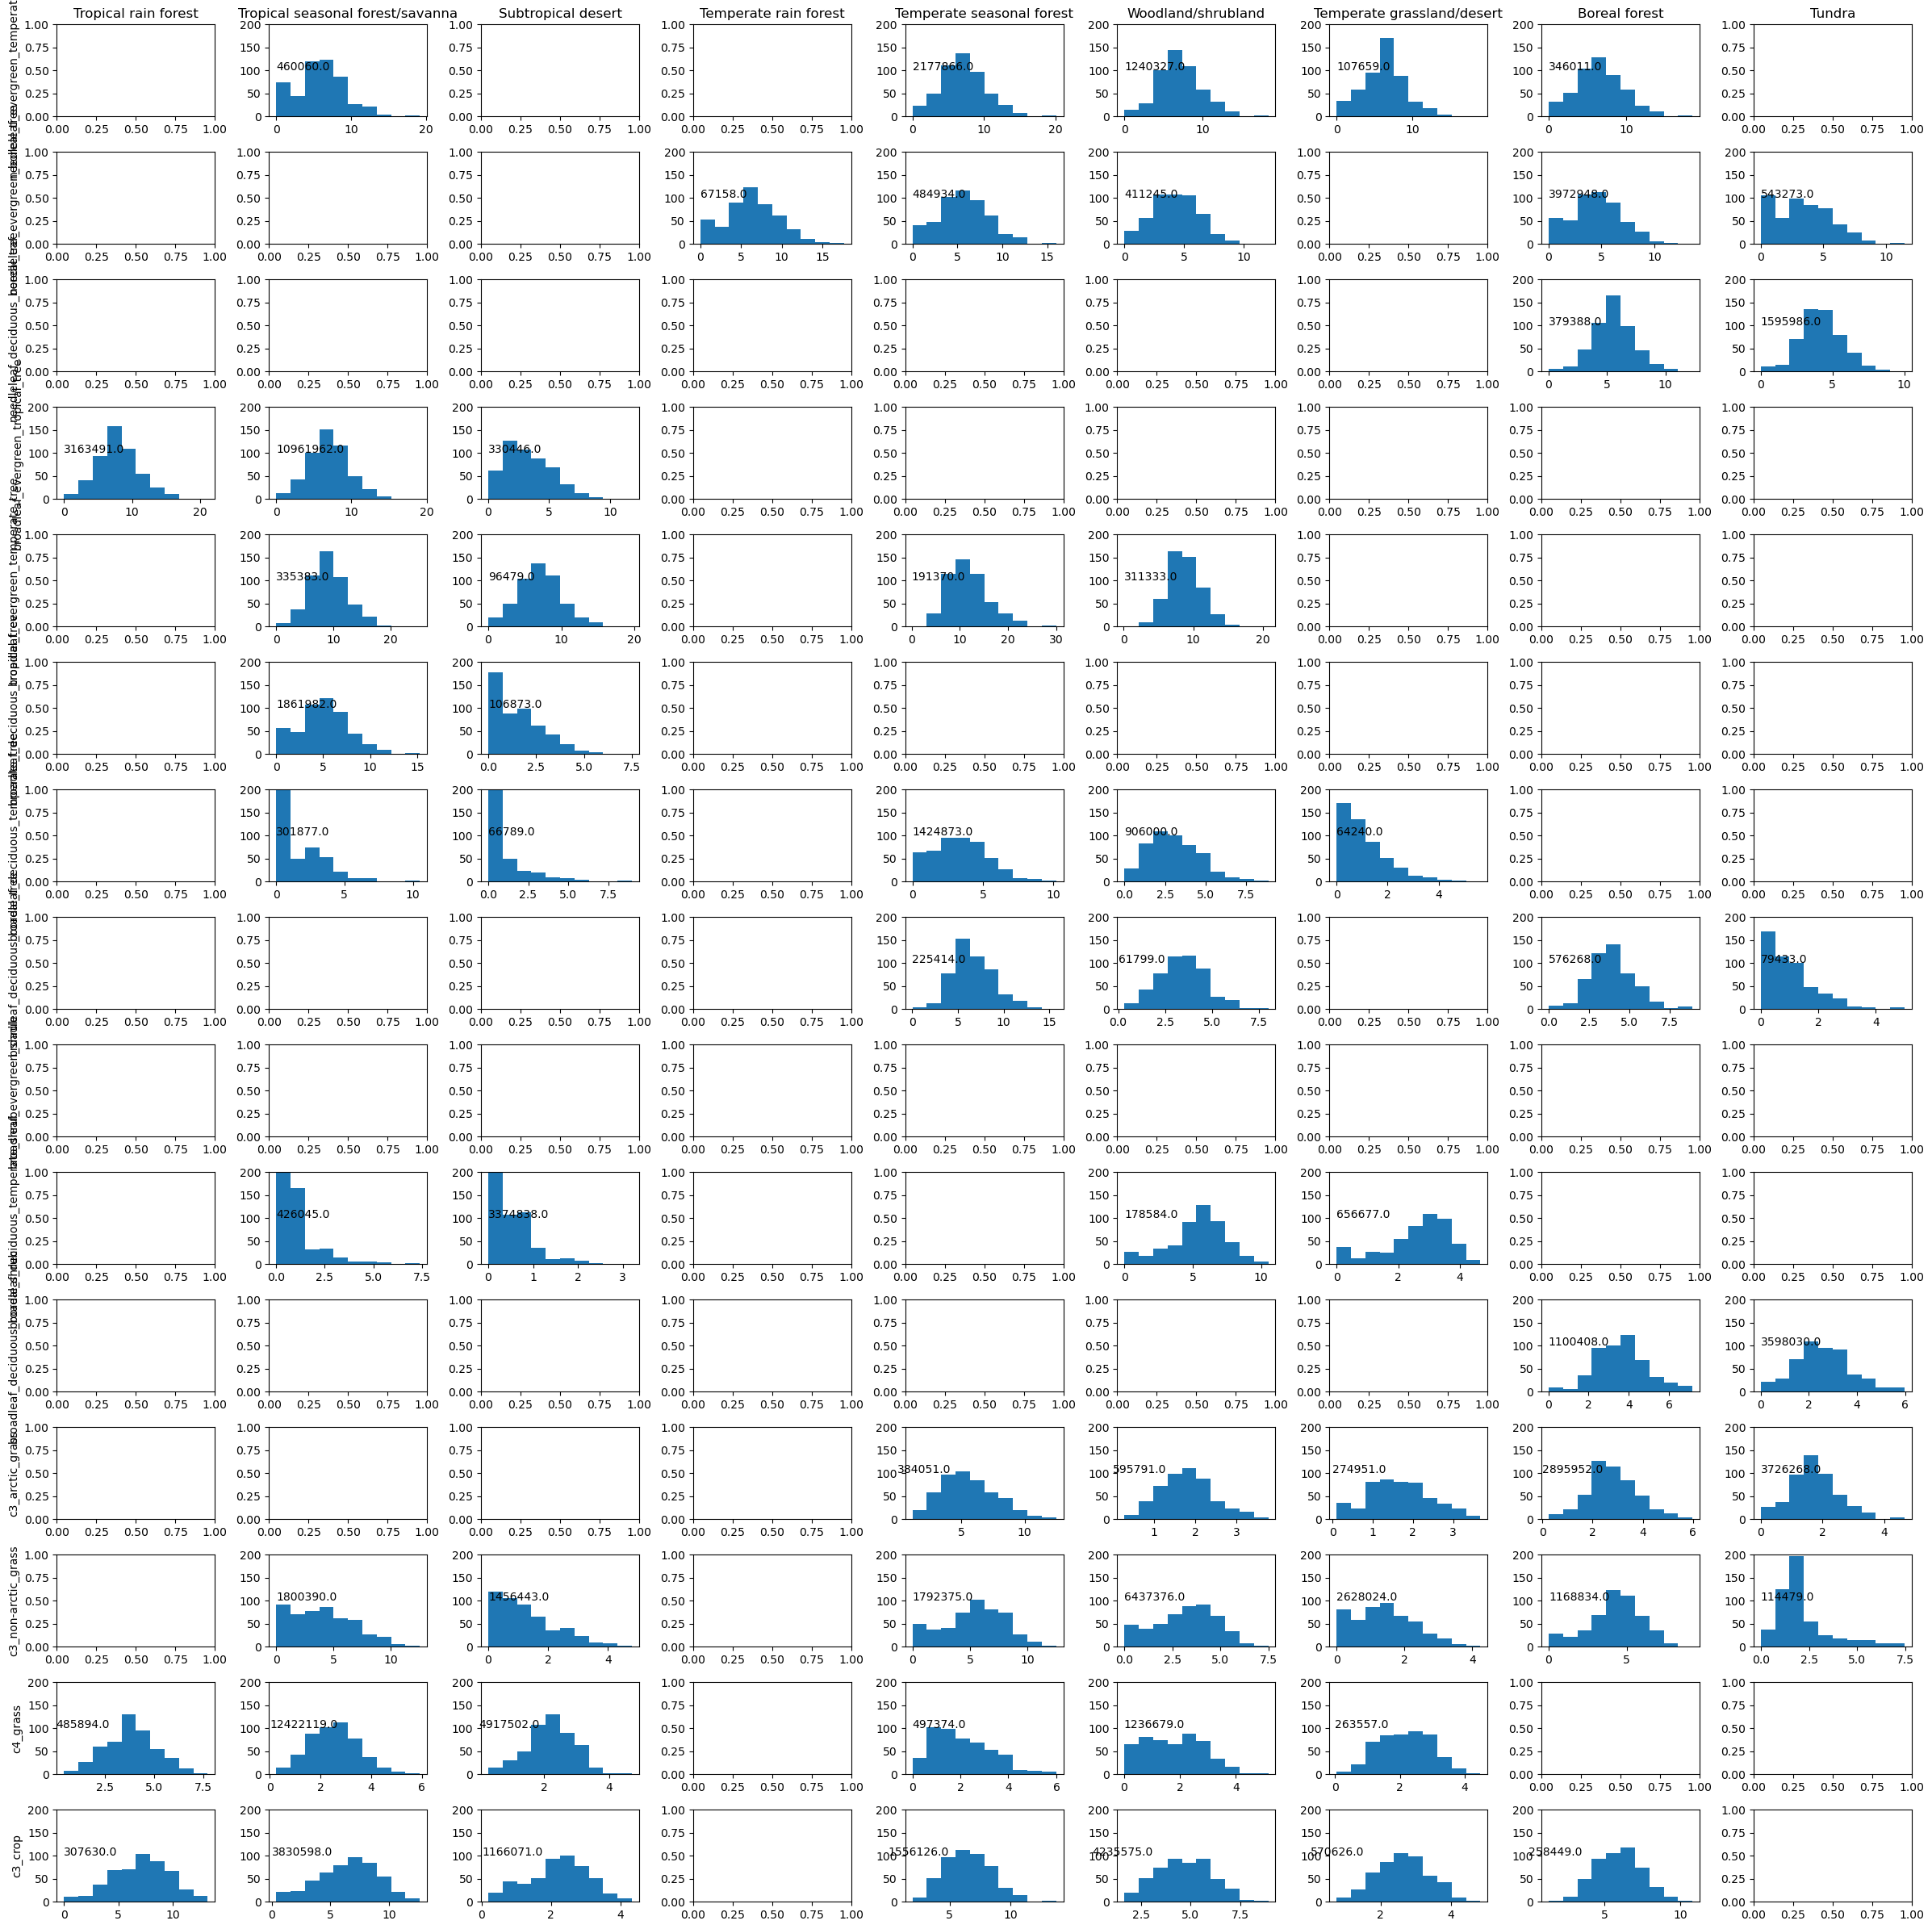

In [23]:
plt.figure(figsize=[24,24])
plt.rcParams.update({'font.size': 10})

da_in = dapb
i = 1
for p in range(1,16):
    da_p = da_in.isel(pb=da_in.pft==p)
    for b in range(1,10):    
        da_pb = da_p.isel(pb=da_p.biome==b)
        
        plt.subplot(15,9,i)
        if ~np.isnan(da_pb[0][0]):
            plt.hist(da_pb[0])
            pb = p*10+b-10
            plt.text(0,100,np.round(asum.isel(pb=pb).values))  
            plt.ylim([0,200])
        if (p==1):
            plt.title(biome_names[b])
        if (b==1):
            plt.ylabel(pft_names[p])
        i = i+1
plt.tight_layout()
plt.savefig('./figs/PFTxBiome_LAImax.png')

In [20]:
# Excluding PFT7 biome 2 & 3 and PFT10 biome 2 & 3 (lots of zeros)
pb_index = {}
pb_index[pft_names[1]] = [2,5,6,7,8]
pb_index[pft_names[2]] = [4,5,6,8,9]
pb_index[pft_names[3]] = [8,9]
pb_index[pft_names[4]] = [1,2,3]
pb_index[pft_names[5]] = [2,3,5,6]
pb_index[pft_names[6]] = [2,3]
pb_index[pft_names[7]] = [5,6,7]
pb_index[pft_names[8]] = [5,6,8,9]
pb_index[pft_names[9]] = []
pb_index[pft_names[10]] = [6,7]
pb_index[pft_names[11]] = [8,9]
pb_index[pft_names[12]] = [5,6,7,8,9] 
pb_index[pft_names[13]] = [2,3,5,6,7,8]
pb_index[pft_names[14]] = [1,2,3,5,6,7] 
pb_index[pft_names[15]] = [1,2,3,5,6,7,8]

### Train and save emulators

In [89]:
# Define kernels

kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))

kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))

kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)

kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
default_kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias
grass_kernel = kernel_linear*kernel_RBF+kernel_matern32

INFO:tensorflow:Assets written to: ./models/pft12_biome5/assets
INFO:tensorflow:Assets written to: ./models/pft12_biome6/assets
INFO:tensorflow:Assets written to: ./models/pft12_biome7/assets
INFO:tensorflow:Assets written to: ./models/pft12_biome8/assets
INFO:tensorflow:Assets written to: ./models/pft12_biome9/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome2/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome3/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome5/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome6/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome7/assets
INFO:tensorflow:Assets written to: ./models/pft13_biome8/assets


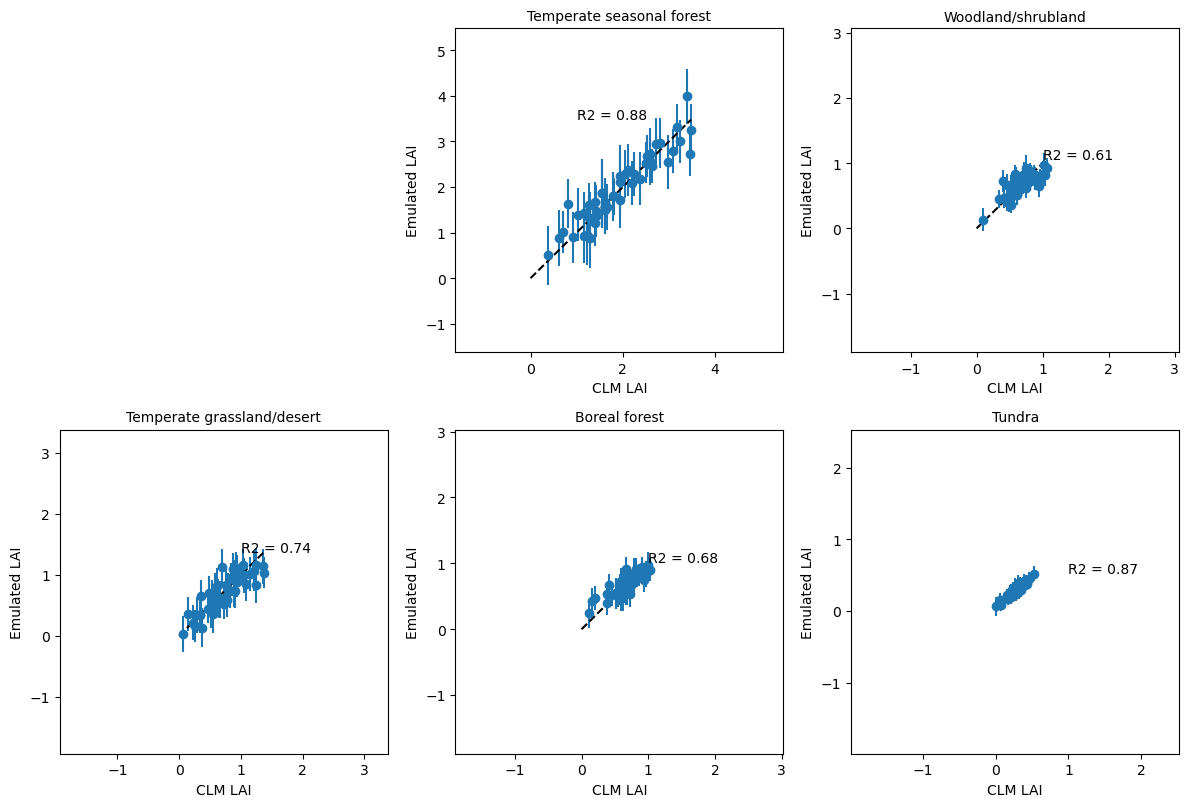

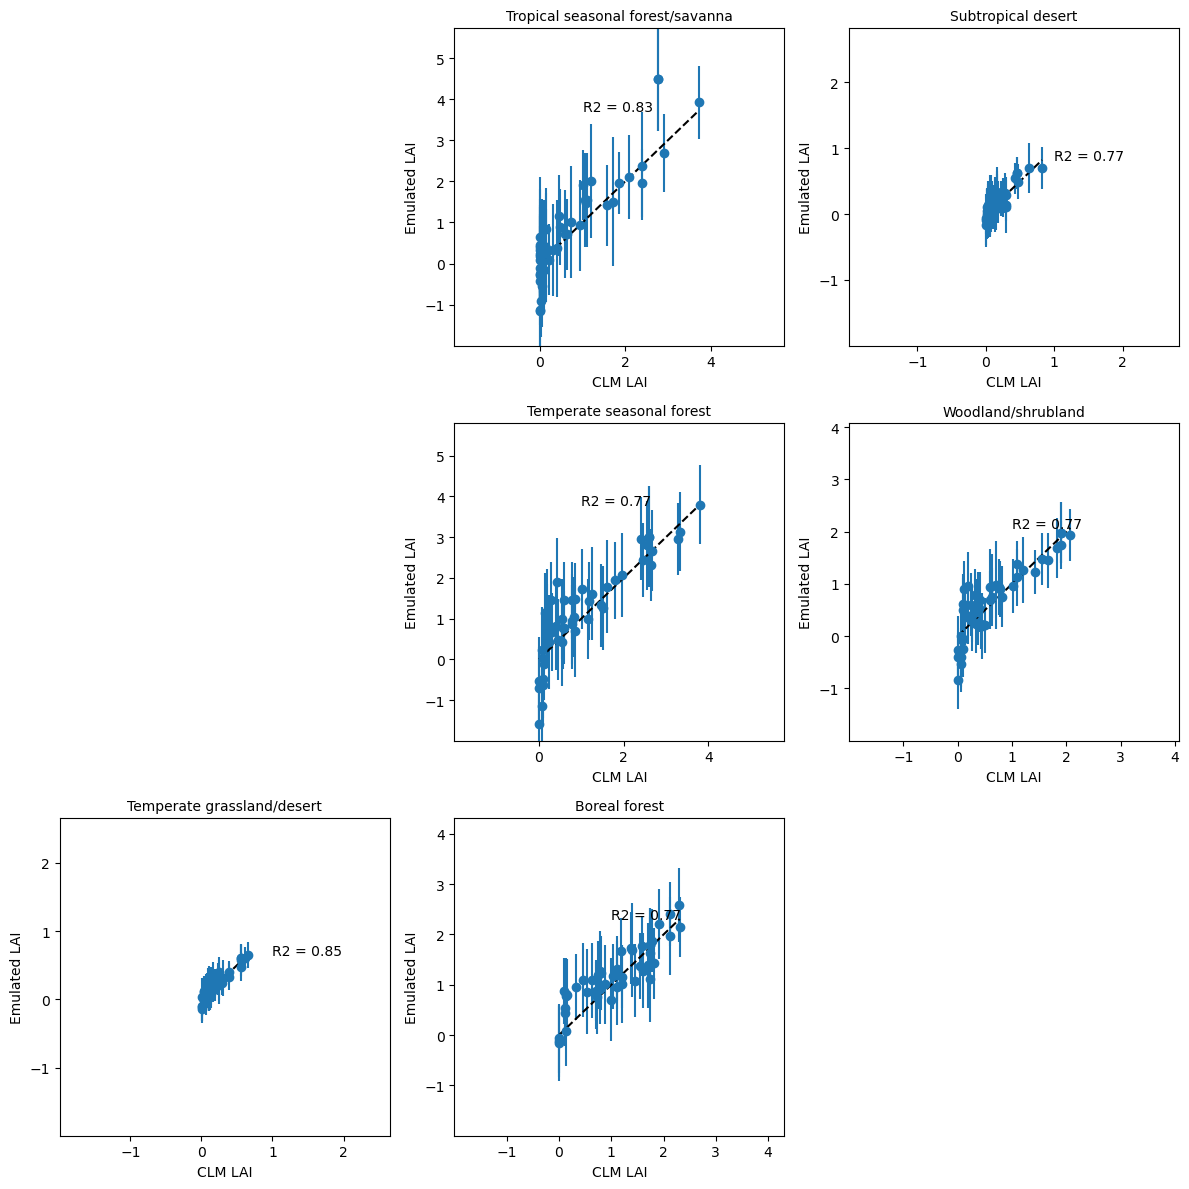

In [90]:
# Train emulators 
# For all TREE and SHRUB PFTs using annual maximum LAI
# For Grasses and crops, use annual mean LAI

da_in = dapb # biome mean of LAI annual max
for p in range(1,16):
    plt.figure(figsize=[12,12])
    plt.rcParams.update({'font.size': 10})

    if (p<12):
        da_p = da_in.isel(pb=da_in.pft==p)
    else: # grasses use annual mean LAI
        da_p = dapb_mean.isel(pb=dapb_mean.pft==p)
    
    kernel=default_kernel
    if (p==12) | (p==13):
        kernel = grass_kernel
    
    for i,b in enumerate(pb_index[pft_names[p]]):
        da_pb = da_p.isel(pb=da_p.biome==b)
        
        X_train = lhc_params.values
        y_train = da_pb[0][1:].values.reshape(-1,1)
        
        model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000))

        # save model
        model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
        savedir = str('./models/pft'+str(p)+'_biome'+str(b))
        tf.saved_model.save(model, savedir)
        
        # plot validation
        X_test = embe_params.values
        if (p<12):
            val_da_p = EmBE_dapb.isel(pb=EmBE_dapb.pft==p)
        else: # grasses use annual mean LAI
            val_da_p = EmBE_dapb_mean.isel(pb=EmBE_dapb_mean.pft==p)
        val_da_pb = val_da_p.isel(pb=val_da_p.biome==b)
        y_test = val_da_pb[0].values.reshape(-1,1)
        
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5
        
        r = np.corrcoef(y_test.flatten(),y_pred.numpy().flatten())
        r2 = r[0,1]**2
        
        plt.subplot(3,3,b)
        plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
        plt.text(1,np.max(y_test.flatten()),'R2 = '+str(np.round(r2,2)),fontsize=10)
        plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
        plt.xlabel('CLM LAI')
        plt.ylabel('Emulated LAI')
        plt.xlim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.ylim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.title(biome_names[b],fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./figs/emulator_validation_pft'+str(p)+'.png')

### Sample and predict

In [21]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']
col_names = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0','froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [22]:
#randomly sample universal parameters
np.random.seed(444)
n_usamp = 5000
u_sample = get_random_params(len(u_params), n_usamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/PxB_universal_sample_12-28.txt", u_sample,delimiter=',')

In [23]:
# randomly sample PFT parameters
np.random.seed(22)
n_psamp = 500
pft_sample = get_random_params(len(pft_params), n_psamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/PxB_pft_sample_12-28.txt", pft_sample,delimiter=',')

In [24]:
# concatenate sample
for u in range(n_usamp):
    if (u==0):
        sample = np.concatenate((np.tile(u_sample[u,:],(n_psamp,1)),pft_sample),axis=1)
    else:
        s = np.concatenate((np.tile(u_sample[u,:],(n_psamp,1)),pft_sample),axis=1)
        sample = np.concatenate((sample,s),axis=0)
        
df_s = pd.DataFrame(sample,columns=col_names)
df_sample = df_s[lhc_params.columns]

In [25]:
for p in range(1,16):
    print(p)
    for i,b in enumerate(pb_index[pft_names[p]]):
        loaded_emulator = tf.saved_model.load('./models/pft'+str(p)+'_biome'+str(b))
        y_pred, y_pred_var = loaded_emulator.predict(df_sample.values)

        # save mean
        file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'.npy'
        np.save(file1,y_pred.numpy())
        # save variances
        file2 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'_var.npy'
        np.save(file2,y_pred_var.numpy())

1


2023-12-28 21:03:51.630803: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-28 21:03:51.630877: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc60): /proc/driver/nvidia/version does not exist
2023-12-28 21:03:51.647836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2
3
4
5
6
7
8
9
10
11
12
13
14
15


### Biome GPP

In [26]:
biome_names = whit.biome_name.values

In [27]:
# CLM-PPE
dvs=['GPP']
htape='h0'
yr0=2007
yr1=2013
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [28]:
la = get_la()
gpp=bmean(amean(ds.GPP).mean(dim='year'),la).compute()

In [29]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [32]:
# load validation data
dvs=['GPP']
htape='h0'
ds_embe=get_exp('EmBE',dvs=dvs,tape=htape,yy=(2007,2013))

t=slice(str(2007),str(2013))
e = slice(1,49) # drop first ensemble member (it's junk)
ds_EmBE = ds_embe.sel(time=t,ens=e)

In [33]:
EmBE_gpp = bmean(amean(ds_EmBE.GPP).mean(dim='year'),la).compute()

In [34]:
# load parameter sets 
lhckey = '/glade/work/linnia/CLM-PPE-LAI_tests/exp1_EmBE/psets_exp1_EmBE_230419.txt'
df = pd.read_csv(lhckey)
embe_params = df.drop(columns='member')

In [35]:
# Define kernels
from esem import gp_model
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))

kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))

kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)

kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias

1
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./models/gpp/biome1/assets
2
INFO:tensorflow:Assets written to: ./models/gpp/biome2/assets
3
INFO:tensorflow:Assets written to: ./models/gpp/biome3/assets
4
INFO:tensorflow:Assets written to: ./models/gpp/biome4/assets
5
INFO:tensorflow:Assets written to: ./models/gpp/biome5/assets
6
INFO:tensorflow:Assets written to: ./models/gpp/biome6/assets
7
INFO:tensorflow:Assets written to: ./models/gpp/biome7/assets
8
INFO:tensorflow:Assets written to: ./models/gpp/biome8/assets
9
INFO:tensorflow:Assets written to: ./models/gpp/biome9/assets


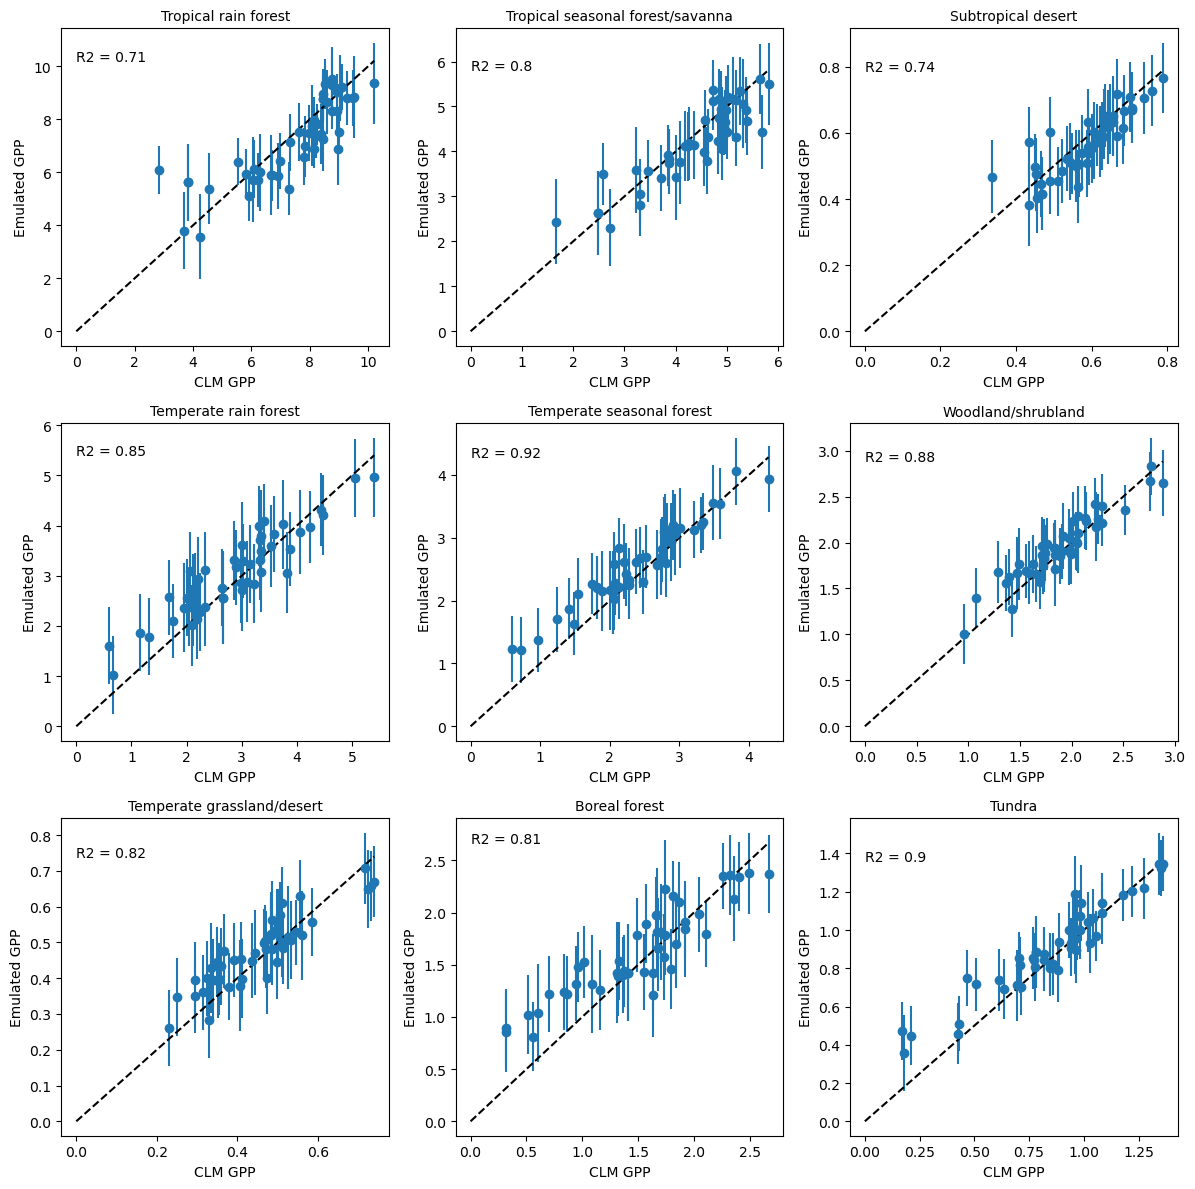

In [36]:
# Train emulators 
da_in = gpp # biome mean of GPP annual mean
scaler = 24*60*60 # (kgC/m2/day)

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 10})

for b in range(1,10):
    print(b)

    X_train = lhc_params.values
    y_train = da_in.isel(biome=b)[1:].values.reshape(-1,1)*scaler
    
    model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

    # save model
    model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
    savedir = str('./models/gpp/biome'+str(b))
    tf.saved_model.save(model, savedir)

    # plot validation
    X_test = embe_params.values
    # get y_data
    y_test = EmBE_gpp.isel(biome=b).values.reshape(-1,1)*scaler

    y_pred, y_pred_var = model.predict_y(X_test)
    sd = y_pred_var.numpy().flatten()**0.5

    r = np.corrcoef(y_test.flatten(),y_pred.numpy().flatten())
    r2 = r[0,1]**2

    plt.subplot(3,3,b)
    plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
    plt.text(0,np.max(y_test.flatten()),'R2 = '+str(np.round(r2,2)),fontsize=10)
    plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
    plt.xlabel('CLM GPP')
    plt.ylabel('Emulated GPP')
    #plt.xlim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
    #plt.ylim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
    plt.title(biome_names[b],fontsize=10)

plt.tight_layout()
plt.savefig('./figs/emulator_validation_GPP.png')

#### Sample and predict

In [105]:
# concatenate sample
for u in range(n_usamp):
    if (u==0):
        sample = np.concatenate((np.tile(u_sample[u,:],(n_psamp,1)),pft_sample),axis=1)
    else:
        s = np.concatenate((np.tile(u_sample[u,:],(n_psamp,1)),pft_sample),axis=1)
        sample = np.concatenate((sample,s),axis=0)
        
df_s = pd.DataFrame(sample,columns=col_names)
df_sample = df_s[lhc_params.columns]

In [37]:
for b in range(1,10):
        loaded_emulator = tf.saved_model.load('./models/gpp/biome'+str(b))
        y_pred, y_pred_var = loaded_emulator.predict(df_sample.values)

        # save mean
        file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_GPP_biome'+str(b)+'.npy'
        np.save(file1,y_pred.numpy())
        # save variances
        file2 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_GPP_biome'+str(b)+'_var.npy'
        np.save(file2,y_pred_var.numpy())

## GPP PFTxBiome

In [ ]:
biome_names = whit.biome_name.values

In [ ]:
# load LHC parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [ ]:
# CLM-PPE
dvs=['GPP']
htape='h0'
yr0=2007
yr1=2013
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [ ]:
gpp = amean(ds.GPP).mean(dim='year').compute()

In [ ]:
lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
dapb=pbmean(gpp,a)
dapb_gpp = dapb.mean(dim='year')

In [ ]:
# load validation data

# load parameter sets 
lhckey = '/glade/work/linnia/CLM-PPE-LAI_tests/exp1_EmBE/psets_exp1_EmBE_230419.txt'
df = pd.read_csv(lhckey)
embe_params = df.drop(columns='member')


dvs=['GPP']
htape='h0'
ds_embe=get_exp('EmBE',dvs=dvs,tape=htape,yy=(2007,2013))

t=slice(str(2007),str(2013))
e = slice(1,49) # drop first ensemble member (it's junk)
ds_EmBE = ds_embe.sel(time=t,ens=e)

In [ ]:
gpp_EmBE = amean(ds_EmBE.GPP).mean(dim='year').compute()

lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
dapb=pbmean(gpp_EmBE,a)
dapb_gpp_EmBE = dapb.mean(dim='year')

In [ ]:
# Define kernels
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=10, lengthscales = np.tile(10,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))

kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))

kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)

kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_RBF + kernel_poly + kernel_bias

In [ ]:
# Train emulators 

da_in = dapb_gpp
for p in range(1,16):
    plt.figure(figsize=[12,12])
    plt.rcParams.update({'font.size': 10})
    
    da_p = da_in.isel(pb=da_in.pft==p)

    for i,b in enumerate(pb_index[pft_names[p]]):
        da_pb = da_p.isel(pb=da_p.biome==b)
        
        X_train = lhc_params.values
        y_train = da_pb[0][1:].values.reshape(-1,1)
        
        model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000))

        # save model
        model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
        savedir = str('./models/gpp/pft'+str(p)+'_biome'+str(b))
        tf.saved_model.save(model, savedir)
        
        # plot validation
        X_test = embe_params.values

        val_da_p = dapb_gpp_EmBE.isel(pb=dapb_gpp_EmBE.pft==p)
        val_da_pb = val_da_p.isel(pb=val_da_p.biome==b)
        y_test = val_da_pb[0].values.reshape(-1,1)
        
        y_pred, y_pred_var = model.predict_y(X_test)
        sd = y_pred_var.numpy().flatten()**0.5
        
        r = np.corrcoef(y_test.flatten(),y_pred.numpy().flatten())
        r2 = r[0,1]**2
        
        plt.subplot(3,3,b)
        plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=2*sd, fmt="o")
        plt.text(1,np.max(y_test.flatten()),'R2 = '+str(np.round(r2,2)),fontsize=10)
        plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
        plt.xlabel('CLM GPP')
        plt.ylabel('Emulated GPP')
        plt.xlim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.ylim([np.min(y_test.flatten())-2,np.max(y_test.flatten())+2])
        plt.title(biome_names[b],fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./figs/emulator_validation_GPP_pft'+str(p)+'.png')